# Heat Map

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import matplotlib

/Users/tianlei/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
train = pd.read_csv('train.csv',index_col = 0)
test = pd.read_csv('test.csv',index_col = 0)
plt.rcParams['figure.figsize'] = 7,8
train = train.drop(columns = ['YrBlt','Closing_Date','Listing_Date','Accept_Date'])
test = test.drop(columns = ['YrBlt','Closing_Date','Listing_Date','Accept_Date'])
test = test[(test['Freq'] != 'B') & (test['Freq'] != 'Q')]
test = test[(test['Area'] != 'San Jose') & (test['Area'] != 'SJOS - San Jose')]
train = train.fillna('(Missing)')
test = test.fillna('(Missing)')

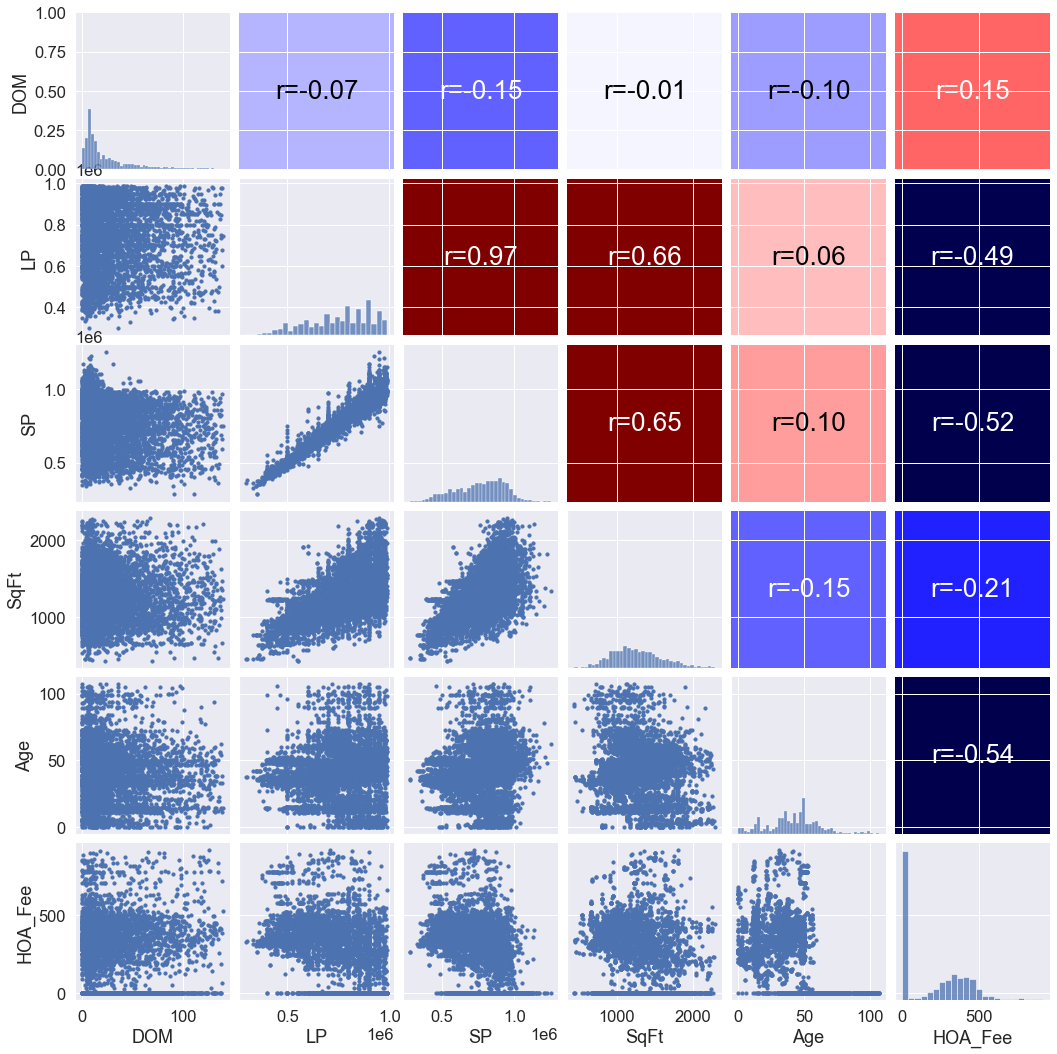

In [3]:
# plot heat map for numeric features
#https://stackoverflow.com/questions/66108908/how-to-combine-a-pairplot-and-a-triangular-heatmap
def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3]) ) / 2
    ax.annotate(f"r={r:.2f}", xy=(.5, .5), xycoords=ax.transAxes,
                color='white' if lightness < 0.7 else 'black', size=26, ha='center', va='center')

num = ['DOM', 'LP', 'SP', 'SqFt', 'Age', 'HOA_Fee']
heatmap = train[num]
sns.set(font_scale=1.5)
g = sns.PairGrid(heatmap)
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.histplot, kde=False)
g.map_upper(corrfunc, cmap=plt.get_cmap('seismic'), norm=plt.Normalize(vmin=-.5, vmax=.5))
g.fig.subplots_adjust(wspace=0.06, hspace=0.06) # equal spacing in both directions
#g.fig.suptitle('Relationship of Features')
plt.show()
g.savefig('heatmap.png') 

# Linear Regression

In [4]:
# split between dependent and independent variables
train_X = train.drop(columns = ['SP'])
train_y = train['SP']
test_X = test.drop(columns = ['SP'])
test_y = test['SP']

In [5]:
#check VIF for numeric features
def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)
numeric = ['DOM', 'LP', 'SqFt','BR','Bth','GarSp', 'HOA_Fee','Age','Zip','Week_in_month_Accept_Date', 'Week_in_month_Listing_Date']
VIF(train_X, numeric)

DOM                           1.027829
LP                            2.572546
SqFt                          3.203172
BR                            3.014533
Bth                           1.986148
GarSp                         1.423149
HOA_Fee                       2.500705
Age                           1.874661
Zip                           1.045816
Week_in_month_Accept_Date     1.002021
Week_in_month_Listing_Date    1.001542
dtype: float64

In [6]:
# create formula
col = train.drop(columns = ['SP'])
f = 'SP ~ ' + ' + '.join(col)

In [7]:
f

'SP ~ DOM + LP + BT + SqFt + BR + Bth + Gar + GarSp + HOA_Fee + Freq + Age + Area + Zip + Month_Accept_Date + Week_in_month_Accept_Date + Month_Listing_Date + Week_in_month_Listing_Date'

In [8]:
#model building
model = smf.ols(formula = f,data = train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     SP   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2432.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:43:59   Log-Likelihood:                -78826.
No. Observations:                6616   AIC:                         1.578e+05
Df Residuals:                    6563   BIC:                         1.581e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

([<matplotlib.axis.YTick at 0x7fc080f15eb8>,
 [Text(0, 0, 'BT[T.SFH]'),
  Text(0, 1, 'BT[T.TH]'),
  Text(0, 2, 'Gar[T.N]'),
  Text(0, 3, 'Gar[T.Y]'),
  Text(0, 4, 'Freq[T.A]'),
  Text(0, 5, 'Freq[T.M]'),
  Text(0, 6, 'Area[T.Almaden Valley]'),
  Text(0, 7, 'Area[T.Alum Rock]'),
  Text(0, 8, 'Area[T.Berryessa]'),
  Text(0, 9, 'Area[T.Blossom Valley]'),
  Text(0, 10, 'Area[T.Cambrian]'),
  Text(0, 11, 'Area[T.Campbell]'),
  Text(0, 12, 'Area[T.Central San Jose]'),
  Text(0, 13, 'Area[T.Cupertino]'),
  Text(0, 14, 'Area[T.Evergreen]'),
  Text(0, 15, 'Area[T.Santa Clara County]'),
  Text(0, 16, 'Area[T.Santa Teresa]'),
  Text(0, 17, 'Area[T.South San Jose]'),
  Text(0, 18, 'Area[T.Willow Glen]'),
  Text(0, 19, 'Month_Accept_Date[T.Aug]'),
  Text(0, 20, 'Month_Accept_Date[T.Dec]'),
  Text(0, 21, 'Month_Accept_Date[T.Feb]'),
  Text(0, 22, 'Month_Accept_Date[T.Jan]'),
  Text(0, 23, 'Month_Accept_Date[T.Jul]'),
  Text(0, 24, 'Month_Accept_Date[T.Jun]'),
  Text(0, 25, 'Month_Accept_Date[T.Mar]'

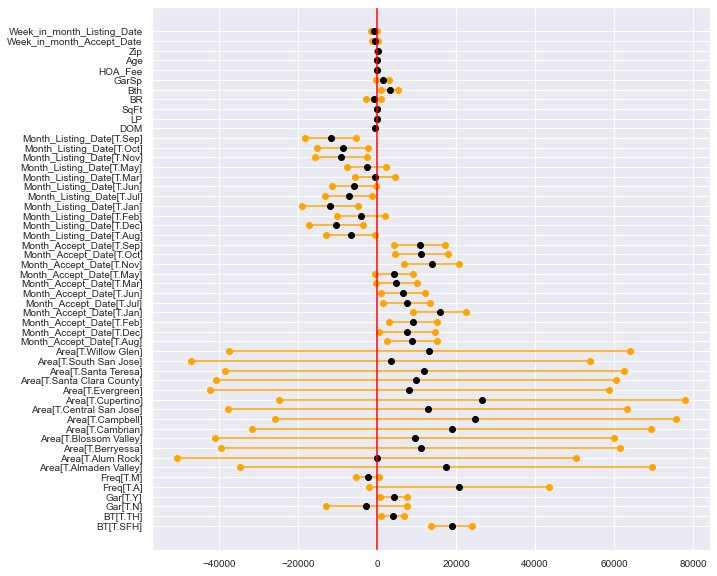

In [9]:

data_dict = {}
data_dict['category'] = list(model.params.to_dict().keys())[1:]
data_dict['lower'] = model.conf_int()[0][1:]
data_dict['upper'] = model.conf_int()[1][1:]
data_dict['coef'] = model.params[1:]
dataset = pd.DataFrame(data_dict)

figure(figsize=(10, 10))
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
for lower,upper,coef,y in zip(dataset['lower'],dataset['upper'], dataset['coef'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')

plt.plot(dataset['coef'], range(len(dataset)), 'ro',color = 'black')
plt.axvline(x = 0, color = 'red')
plt.yticks(range(len(dataset)),list(dataset['category']))

In [10]:
#drop Gar, Freq, BR, GarSp, GarSp, Age, Week_in_month_Accept_date due to not significant

# create formula
col = train.drop(columns = ['SP','Gar', 'Freq', 'BR', 'GarSp', 'Age', 'Week_in_month_Accept_Date'])
f = 'SP ~ ' + ' + '.join(col)
#model building
model = smf.ols(formula = f,data = train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     SP   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     2860.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:44:01   Log-Likelihood:                -78845.
No. Observations:                6616   AIC:                         1.578e+05
Df Residuals:                    6571   BIC:                         1.581e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [11]:
predict_y = model.predict(test_X)

In [12]:
predict_y

0       898139.102066
1       838055.676313
2       823830.962117
3       552207.161623
4       966311.421253
            ...      
2995    619830.623387
2996    906547.918452
2997    743735.197689
2998    678108.922749
2999    705817.498920
Length: 2983, dtype: float64

In [13]:
#calculate OSR2, MSE, MAE
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

def MAE(y_test, y_pred):
    
    return (np.mean(abs(y_test - y_pred)))

def RMSE(y_test, y_pred):
    
    return np.sqrt(np.mean((y_test - y_pred)**2))
print('OSR2', OSR2(train_y,test_y,predict_y))
print('RMSE', RMSE(test_y,predict_y))
print('MAE', MAE(test_y,predict_y))

OSR2 0.8959296796836413
RMSE 59894.36708203091
MAE 39769.78346714397


# Ridge Regression

In [14]:
# train = train.drop(columns = ['YrBlt','Closing_Date','Accept_Date','Listing_Date'])
# test = test.drop(columns = ['YrBlt','Closing_Date','Accept_Date','Listing_Date'])
#get dummies
train = pd.get_dummies(train, columns = ['BT','Gar','Freq','Area','Zip','Month_Accept_Date','Month_Listing_Date'])
test = pd.get_dummies(test, columns = ['BT','Gar','Freq','Area','Zip','Month_Accept_Date','Month_Listing_Date'])


In [15]:
#split dependent and independent variables
train_X = train.drop(columns = ['SP'])
train_y = train['SP']
test_X = test.drop(columns = ['SP'])
test_y = test['SP']
test_X['Month_Accept_Date_Oct'] = [0] * len(test_X)

In [16]:
test_X

,DOM,LP,SqFt,BR,Bth,GarSp,HOA_Fee,Age,Week_in_month_Accept_Date,Week_in_month_Listing_Date,...,Month_Listing_Date_Feb,Month_Listing_Date_Jan,Month_Listing_Date_Jul,Month_Listing_Date_Jun,Month_Listing_Date_Mar,Month_Listing_Date_May,Month_Listing_Date_Nov,Month_Listing_Date_Oct,Month_Listing_Date_Sep,Month_Accept_Date_Oct
0,12,889500,1464,2,2,2.0,210.0,7.0,4,2,...,0,0,0,0,0,0,0,0,0,0
1,6,799999,1398,4,2,2.0,0.0,49.0,4,3,...,0,0,0,0,0,0,0,0,0,0
2,11,799998,1353,3,2,2.0,0.0,49.0,4,2,...,0,0,0,0,0,0,0,0,0,0
3,25,549000,1094,2,2,0.0,463.0,29.0,4,4,...,0,0,0,0,0,0,1,0,0,0
4,10,949000,1065,3,2,2.0,0.0,49.0,4,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,28,619000,850,2,2,1.0,349.0,29.0,2,2,...,0,0,0,0,0,0,0,0,1,0
2996,18,888000,1272,3,2,2.0,0.0,106.0,2,3,...,0,0,0,0,0,0,0,0,1,0
2997,33,739950,1006,2,2,0.0,400.0,30.0,2,1,...,0,0,0,0,0,0,0,0,1,0
2998,5,667053,1233,2,2,1.0,535.0,36.0,2,1,...,0,0,0,0,0,0,0,1,0,0


In [17]:
def one_standard_error_rule(model, results, param_grid, n_splits, neg_mean_squared_error=True):
    
    assert neg_mean_squared_error == True # function is defined specifically for neg_mean_squared_error
    
    #find model with minimum error, then select the simplest model
    #whose mean falls within 1 standard deviation of the minimum
    
    range_x = param_grid # results['param_'+list(param_grid.keys())[0]].data
    std_vs_x  = pd.Series(results['std_test_score'], index = range_x)
    sem_vs_x  = std_vs_x/np.sqrt(n_splits)
    
    mean_vs_x = pd.Series(results['mean_test_score'], index = range_x)        
    mean_vs_x = mean_vs_x*(-1)
    
    x_min = mean_vs_x.idxmin()
    sem = sem_vs_x[x_min]
    

    if (model=='pcr'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.min()
    elif (model=='ridge') | (model=='lasso'):
        x_1se = mean_vs_x[mean_vs_x <= min(mean_vs_x) + sem].index.max()
        
    #x_1se_idx = int(np.argwhere(range_x == x_1se)[0])
    
    return x_min, x_1se

In [18]:
alpha_grid = {'alpha': np.logspace(-1, 5, num=50, base=10)}

rr = Ridge(random_state=88)
rr_cv = GridSearchCV(rr, alpha_grid, scoring='neg_root_mean_squared_error', cv=10)
rr_cv.fit(train_X, train_y)



GridSearchCV(cv=10, estimator=Ridge(random_state=88),
             param_grid={'alpha': array([1.00000000e-01, 1.32571137e-01, 1.75751062e-01, 2.32995181e-01,
       3.08884360e-01, 4.09491506e-01, 5.42867544e-01, 7.19685673e-01,
       9.54095476e-01, 1.26485522e+00, 1.67683294e+00, 2.22299648e+00,
       2.94705170e+00, 3.90693994e+00, 5.17947468e+00, 6.86648845e+00,
       9.10298178e+00, 1.20679264e+01, 1...
       2.68269580e+02, 3.55648031e+02, 4.71486636e+02, 6.25055193e+02,
       8.28642773e+02, 1.09854114e+03, 1.45634848e+03, 1.93069773e+03,
       2.55954792e+03, 3.39322177e+03, 4.49843267e+03, 5.96362332e+03,
       7.90604321e+03, 1.04811313e+04, 1.38949549e+04, 1.84206997e+04,
       2.44205309e+04, 3.23745754e+04, 4.29193426e+04, 5.68986603e+04,
       7.54312006e+04, 1.00000000e+05])},
             scoring='neg_root_mean_squared_error')

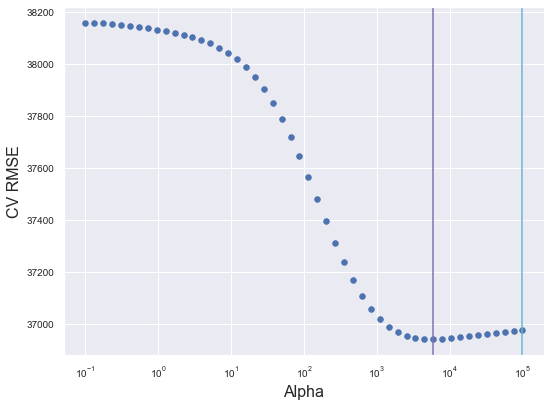

In [19]:
range_alpha = rr_cv.cv_results_['param_alpha'].data
MSE_scores = rr_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='ridge',
                                       results=rr_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV RMSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
#plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [20]:
#using best ridge to predict
predict_y = rr_cv.predict(test_X)
print('OSR2', OSR2(train_y,test_y,predict_y))
print('RMSE', RMSE(test_y,predict_y))
print('MAE', MAE(test_y,predict_y))

OSR2 0.9003437622626614
RMSE 58610.41251768119
MAE 38244.629254708336


In [21]:
print('Alpha one standard error rule:', x_1se)

Alpha one standard error rule: 100000.0


In [22]:
#using one std rule to predict
rr_cv_std = GridSearchCV(rr, {'alpha': [x_1se]}, scoring='neg_root_mean_squared_error', cv=10)
rr_cv_std.fit(train_X, train_y)
predict_y = rr_cv_std.predict(test_X)
print('OSR2', OSR2(train_y,test_y,predict_y))
print('RMSE', RMSE(test_y,predict_y))
print('MAE', MAE(test_y,predict_y))

OSR2 0.9010256525321843
RMSE 58409.549673280446
MAE 38055.03998682303


In [23]:
#import pickle
#filename = 'ridge.sav'
#pickle.dump(rr_cv_std, open(filename,'wb'))

# Lasso

In [29]:
#grid search for alpha in lasso
alpha_grid = {'alpha': np.logspace(-8, -1, num=50, base=10)}
lasso = Lasso(random_state=88)
lasso_cv = GridSearchCV(lasso, alpha_grid, scoring='neg_root_mean_squared_error', cv=10)
lasso_cv.fit(train_X, train_y)

GridSearchCV(cv=10, estimator=Lasso(random_state=88),
             param_grid={'alpha': array([1.00000000e-08, 1.38949549e-08, 1.93069773e-08, 2.68269580e-08,
       3.72759372e-08, 5.17947468e-08, 7.19685673e-08, 1.00000000e-07,
       1.38949549e-07, 1.93069773e-07, 2.68269580e-07, 3.72759372e-07,
       5.17947468e-07, 7.19685673e-07, 1.00000000e-06, 1.38949549e-06,
       1.93069773e-06, 2.68269580e-06, 3...
       1.00000000e-04, 1.38949549e-04, 1.93069773e-04, 2.68269580e-04,
       3.72759372e-04, 5.17947468e-04, 7.19685673e-04, 1.00000000e-03,
       1.38949549e-03, 1.93069773e-03, 2.68269580e-03, 3.72759372e-03,
       5.17947468e-03, 7.19685673e-03, 1.00000000e-02, 1.38949549e-02,
       1.93069773e-02, 2.68269580e-02, 3.72759372e-02, 5.17947468e-02,
       7.19685673e-02, 1.00000000e-01])},
             scoring='neg_root_mean_squared_error')

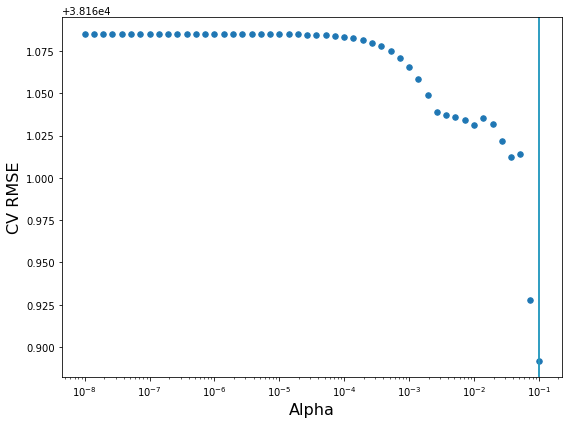

In [30]:
#plot
range_alpha = lasso_cv.cv_results_['param_alpha'].data
MSE_scores = lasso_cv.cv_results_['mean_test_score']*(-1)
x_min, x_1se = one_standard_error_rule(model='lasso',
                                       results=lasso_cv.cv_results_,
                                       param_grid=range_alpha,
                                       n_splits=10,
                                       neg_mean_squared_error=True)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('Alpha', fontsize=16)
plt.ylabel('CV RMSE', fontsize=16)
plt.scatter(range_alpha, MSE_scores, s=30)
plt.axvline(x=x_min, color='m')
plt.axvline(x=x_1se, color='c')
#plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [31]:
#using best Lasso to predict
predict_y = lasso_cv.predict(test_X)
print('OSR2', OSR2(train_y,test_y,predict_y))
print('RMSE', RMSE(test_y,predict_y))
print('MAE', MAE(test_y,predict_y))

OSR2 0.8909239715582623
RMSE 61317.8886716768
MAE 41352.425473355324
